In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ff77dca5b62af43905cfd13213c0d9abd81457c2ea039db1032d5ca0b15278f4
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


# Import Required Libraries

In [2]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist, mnist
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing

In [3]:

(X,y),(X_test,y_test)=fashion_mnist.load_data()  ##Load data

X.shape ## X and X_test to be reshaped to (60000, (28x28)) array 

num_features=784        ## 784 features
num_classes=np.max(y)+1 ## 10 classes

# Reshaping the training and test feature data 
X=np.reshape(X,(X.shape[0],784))
X_test=np.reshape(X_test,(X_test.shape[0],784))

# Normalize the pixel intensities
X=X/255
X_test=X_test/255

def train_val_split(X, y, val_size=0.1):
    np.random.seed(42)
    i = int((1 - val_size) * X.shape[0])         # No of train data sample
    index = np.random.permutation(X.shape[0])
    
    X_train, X_val = np.split(np.take(X,index,axis=0), [i])
    y_train, y_val = np.split(np.take(y,index), [i])
    return X_train, X_val, y_train, y_val
    
X_train, X_val, y_train, y_val=train_val_split(X,y)

### One hot encode the Class_labels (y_val & y_test & y_train)
def one_hot_encode(labels):
  z=np.zeros((10,len(labels)))
  for i in range(0,len(labels)):
    z[labels[i],i]=1  
  return z

y_val_encoded=one_hot_encode(y_val)
y_train_encoded=one_hot_encode(y_train)
y_test_encoded=one_hot_encode(y_test)
y_encoded=one_hot_encode(y)

#####

X=X.T
X_test=X_test.T
X_val=X_val.T
X_train=X_train.T

#####

## Number of samples in training, validation and test set

no_sample_train=X_train.shape[1]
no_sample_val=X_val.shape[1]
no_sample_test=X_test.shape[1]

4422102/4422102 [==============================] - 0s 0us/step


# Activation Functions & Derivatives

In [4]:
def sigmoid(a):
  return 1./(1.+np.exp(-a))

def sigmoid_derivative(a):
  return sigmoid(a)*(1-sigmoid(a))

def tanh(a):
  return np.tanh(a)

def tanh_derivative(a):
  return (1-np.power(tanh(a),2))

def relu(a):
  return np.maximum(0,a)

def relu_derivative(a):
  return (a>0)*1

def identity(a):
  return a

def identity_derivative(a):
  return np.ones((np.shape(a)))

def softmax(a):
  #----
  ## a => np.array 
  #----
  return np.exp(a-np.max(a,axis=0))/(np.sum(np.exp(a-np.max(a,axis=0)),axis=0))  
  ## To prevent overflow error, the numpy array has been subtracted from the maximum value in that numpy array

def derivative_softmax(a,batch_size,num_classes):
  grad_softmax = np.zeros((num_classes, num_classes,batch_size)) # This is designed only for softmax derivative at the final layer
  output=softmax(a)
  for i in range(batch_size):
      diag_output = np.diag(output[:,i])
      grad_softmax[ :, :,i] = diag_output - np.outer(output[:,i], output[:,i])   # interaction_terms in jacobian 
      grad_softmax[np.arange(num_classes), np.arange(num_classes),i] = output[ :,i] * (1 - output[:,i]) # self-interaction terms
  return grad_softmax

# Function to compute loss

In [5]:
def loss_computation(y_true,y_hat,loss,batch_size,lambda_val,parameters,total_layers):

    if loss=='cross_entropy':
        J=(-1*np.sum(np.multiply(y_true,np.log2(y_hat))))/batch_size
     
    elif loss=='mse':
        J=((1/2)*(np.sum(np.power((y_true-y_hat),2))))/batch_size

  # L2 Regularisation
    sum_square_weight=0
    total_layers=total_layers
    for layer in range(1,total_layers):
        sum_square_weight+=np.sum(np.power(parameters['W_'+str(layer)],2))
  
    J+=(lambda_val/(2*batch_size))*sum_square_weight
  
    return J


In [7]:
class NeuralNetwork():
   def __init__(self,num_layers,activation_function,loss,batch_size,lambda_val):
      self.num_layers=num_layers
      self.num_hidden_layers=self.num_layers-2      # Exclude input and output
      self.activation_function=activation_function
      self.loss=loss
      self.batch_size=batch_size
      self.lambda_val=lambda_val
      
   def weight_bias_initialize(self,neurons_per_layer,init):
        

  # neurons_per_layer is a list specifying number of neurons per layer
        self.neurons_per_layer=neurons_per_layer
        self.init=init
        np.random.seed(42)

        self.parameters={}
        self.old_parameters={} ## For momentum, nesterov

        for layer in range(1,len(self.neurons_per_layer)):
            if self.init=='Xavier':
                self.sdev=np.sqrt(2/(self.neurons_per_layer[layer-1]+self.neurons_per_layer[layer]))
                self.parameters['W_'+str(layer)]=np.random.randn(self.neurons_per_layer[layer],self.neurons_per_layer[layer-1])*self.sdev
    
            if init=='random': # Random normal
                self.parameters['W_'+str(layer)]=np.random.randn(self.neurons_per_layer[layer],self.neurons_per_layer[layer-1])*0.01

    
            self.parameters['b_'+str(layer)]=np.zeros((self.neurons_per_layer[layer],1))
  
            self.old_parameters['W_'+str(layer)]=np.zeros((self.neurons_per_layer[layer],self.neurons_per_layer[layer-1]))
            self.old_parameters['b_'+str(layer)]=np.zeros((self.neurons_per_layer[layer],1))
  
        # For adam, rmsprop, nadam
        self.v=self.old_parameters.copy()
        self.m=self.old_parameters.copy()           

        return self.parameters,self.old_parameters,self.v,self.m
    
   def forward_propagation(self,data,parameters):
        
        self.parameters=parameters
        self.data=data
        self.activation = {} # activations
        self.pre_activation = {} # pre-activations
    
        self.activation["H_0"] = self.data # H_0=training data
    
        for layer in range(1, self.num_layers):   # start from hidden layer 
            self.Weight = self.parameters["W_"+str(layer)]
            self.bias = self.parameters["b_"+str(layer)]
        
            self.pre_activation["A_"+str(layer)] = np.matmul(self.Weight,self.activation["H_"+str(layer-1)]) + self.bias    # a_i=W*h_(i-1) + b_i
        
            if layer == self.num_layers-1:
                self.activation["H_"+str(layer)] = softmax(self.pre_activation["A_"+str(layer)])  ## Output layet
            else:
                if self.activation_function == 'sigmoid':
                    self.activation["H_"+str(layer)] = sigmoid(self.pre_activation["A_"+str(layer)]) # h_i=g(a_i), g is the activation function
                elif self.activation_function == 'relu':
                    self.activation["H_"+str(layer)] = relu(self.pre_activation["A_"+str(layer)])
                elif self.activation_function == 'tanh':
                    self.activation["H_"+str(layer)] = tanh(self.pre_activation["A_"+str(layer)])
                elif self.activation_function== 'identity':
                    self.activation["H_"+str(layer)] = identity(self.pre_activation["A_"+str(layer)])

            #####
            # Can add other activation functions here
            #####
                
        self.y_pred = self.activation["H_"+str(self.num_layers-1)]  # output

        return self.y_pred,self.activation,self.pre_activation
    
   def backpropagate(self,y_hat,y_true,activation,pre_activation,parameters):  
    
        self.layers_no_input=self.num_layers-1   ## No. of layers in NN exluding the input
        self.gradient_dA={}      ##Store Gradients wrt to pre-activations
        self.gradient_dH={}      ##Store Gradients wrt to after-activations
        self.parameter_gradient={}  ##Store gradients wrt to weight and bias
        self.y_true=y_true
        self.y_hat=y_hat
        self.pre_activation=pre_activation
        self.activation=activation
        self.parameters=parameters

  # Last_layer
        if self.loss=='cross_entropy':
            self.gradient_dA['dA_'+str(self.layers_no_input)]=-1*(self.y_true-self.y_hat)
  
        elif self.loss=='mse':
          self.gradient_dA['dA_'+str(self.layers_no_input)]=np.einsum('ik,ijk->jk',(self.y_hat-self.y_true),
                                                                      derivative_softmax(self.pre_activation["A_"+str(self.layers_no_input)],self.batch_size,num_classes))
    
  
        for layer in range(self.layers_no_input,0,-1):  # move from Hidden layer L-1 to Hidden layer 1
            self.parameter_gradient['dW_'+str(layer)]=(np.dot(self.gradient_dA['dA_'+str(layer)],self.activation["H_"+str(layer-1)].T)+self.lambda_val*self.parameters['W_'+str(layer)])/self.batch_size
            self.parameter_gradient['db_'+str(layer)]=np.sum(self.gradient_dA['dA_'+str(layer)],axis=1,keepdims=True)/self.batch_size  
    
    
            if layer>1:  
                if self.activation_function=='sigmoid':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*sigmoid_derivative(self.pre_activation["A_"+str(layer-1)])
    
                elif self.activation_function=='relu':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*relu_derivative(self.pre_activation["A_"+str(layer-1)])  

                elif self.activation_function=='tanh':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*tanh_derivative(self.pre_activation["A_"+str(layer-1)])   

                elif self.activation_function=='identity':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*identity_derivative(self.pre_activation["A_"+str(layer-1)])        
                
                ## For other activation functions add here

        return self.parameter_gradient
    
           

   def predict(self,data, parameters):
        self.data=data
        self.parameters=parameters
        self.output, _, _ = self.forward_propagation(self.data, self.parameters)
        self.predictions = np.argmax(self.output, axis=0)
        return self.predictions
   
   def accuracy(self,true_labels,pred_labels):
        
        return np.sum(true_labels==pred_labels)/len(true_labels)

   
   def loss_plot(self,train_loss,val_loss):
     self.train_loss=train_loss
     self.val_loss=val_loss
     plt.plot(list(range(0,len(self.train_loss))), self.train_loss, 'r', label="Training loss")
     plt.plot(list(range(0,len(self.val_loss))), self.val_loss, 'b', label="Validation loss")
     plt.title("Loss vs Epochs", size=10)
     plt.xlabel("Epochs", size=10)
     plt.ylabel("Loss", size=10)
     plt.legend()
     plt.show()

In [8]:

class NN_optimizers:
  def __init__(self,parameters,gradients,learning_rate,old_parameters,v,m,t,num_layers):
    self.parameters=parameters
    self.learning_rate=learning_rate
    self.old_parameters=old_parameters
    self.gradients=gradients
    self.v=v
    self.m=m
    self.t=t
    self.num_layers=num_layers  

  def sgd(self):
    

    for layer in range(1,self.num_layers): ## Since dictionary has keys 'W_1' to 'W_L'

      self.parameters['W_'+str(layer)]=self.parameters['W_'+str(layer)]-self.learning_rate*self.gradients['dW_'+str(layer)]
      self.parameters['b_'+str(layer)]=self.parameters['b_'+str(layer)]-self.learning_rate*self.gradients['db_'+str(layer)]
  
    return self.parameters
  
  def momentum_gd(self):
    self.beta=0.9
    

    for layer in range(1,self.num_layers):
      self.old_parameters['W_'+str(layer)]=self.beta*self.old_parameters['W_'+str(layer)]+self.gradients['dW_'+str(layer)]
      self.parameters['W_'+str(layer)]-=self.learning_rate*self.old_parameters['W_'+str(layer)]

      self.old_parameters['b_'+str(layer)]=self.beta*self.old_parameters['b_'+str(layer)]+self.gradients['db_'+str(layer)]
      self.parameters['b_'+str(layer)]-=self.learning_rate*self.old_parameters['b_'+str(layer)]
  

    return self.parameters,self.old_parameters

  
#  def nesterov_gd_old(self,train_data,train_label,activation_function,loss,batch_size,lambda_val):
#
#    self.train_data=train_data
#    self.train_label=train_label
#    self.activation_function=activation_function
#    self.loss=loss
#    self.batch_size=batch_size
#    self.lambda_val=lambda_val
#    self.beta=0.9
    

#    for i in range(1,self.num_layers):
#      self.look_ahead_parameters['W_'+str(i)]=self.parameters['W_'+str(i)]-self.beta*self.old_parameters['W_'+str(i)]
#      self.look_ahead_parameters['b_'+str(i)]=self.parameters['b_'+str(i)]-self.beta*self.old_parameters['b_'+str(i)]
#    nn=NeuralNetwork(self.num_layers,activation_function,loss,batch_size,lambda_val)
#    output,H,A=nn.forward_propagation(self.train_data,self.look_ahead_parameters)
#    self.look_ahead_gradients=nn.backpropagate(output,self.train_label,H,A,self.look_ahead_parameters)

#    for i in range(1,self.num_layers):
#      self.old_parameters['W_'+str(i)]=self.beta*self.old_parameters['W_'+str(i)]+self.look_ahead_gradients['dW_'+str(i)]
#      self.parameters['W_'+str(i)]-=self.learning_rate*self.old_parameters['W_'+str(i)]

#      self.old_parameters['b_'+str(i)]=self.beta*self.old_parameters['b_'+str(i)]+self.look_ahead_gradients['db_'+str(i)]
#      self.parameters['b_'+str(i)]-=self.learning_rate*self.old_parameters['b_'+str(i)]

#    return self.parameters,self.old_parameters,self.look_ahead_parameters


  def nesterov_gd(self): # Rewritten NAG
    self.beta=0.9
    
    for layer in range(1,self.num_layers):
      self.old_parameters['W_'+str(layer)]=self.beta*self.old_parameters['W_'+str(layer)]+self.gradients['dW_'+str(layer)]
      self.parameters['W_'+str(layer)]=self.parameters['W_'+str(layer)]-self.learning_rate*(self.beta*self.old_parameters['W_'+str(layer)]+self.gradients['dW_'+str(layer)])

      self.old_parameters['b_'+str(layer)]=self.beta*self.old_parameters['b_'+str(layer)]+self.gradients['db_'+str(layer)]
      self.parameters['b_'+str(layer)]=self.parameters['b_'+str(layer)]-self.learning_rate*(self.beta*self.old_parameters['b_'+str(layer)]+self.gradients['db_'+str(layer)])
       
    return self.parameters, self.old_parameters


  def rmsprop(self):
    self.beta=0.9
    self.epsilon=1e-7

    for layer in range(1,self.num_layers):

      v_dw=self.beta*self.v['W_'+str(layer)]+(1-self.beta)*np.power(self.gradients['dW_'+str(layer)],2)
      v_db=self.beta*self.v['b_'+str(layer)]+(1-self.beta)*np.power(self.gradients['db_'+str(layer)],2)


      self.v['W_'+str(layer)]=v_dw
      self.v['b_'+str(layer)]=v_db

      self.parameters['W_'+str(layer)]-=((self.learning_rate/np.sqrt(v_dw+self.epsilon))*self.gradients['dW_'+str(layer)])
      self.parameters['b_'+str(layer)]-=((self.learning_rate/np.sqrt(v_db+self.epsilon))*self.gradients['db_'+str(layer)])
    return self.parameters, self.v
  

  def adam(self):

    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = 1e-8

    for layers in range(1, self.num_layers):
        m_dw = self.beta1*self.m["W_"+str(layers)] + (1-self.beta1)*self.gradients["dW_"+str(layers)]
        v_dw = self.beta2*self.v["W_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["dW_"+str(layers)],2)

        mw_hat = m_dw/(1.0 - self.beta1**self.t)
        vw_hat = v_dw/(1.0 - self.beta2**self.t)

        self.parameters["W_"+str(layers)] -= (self.learning_rate * mw_hat)/(np.sqrt(vw_hat) + self.epsilon)
 
        self.v["W_"+str(layers)] = v_dw
        self.m["W_"+str(layers)] = m_dw

        m_db = self.beta1*self.m["b_"+str(layers)] + (1-self.beta1)*self.gradients["db_"+str(layers)]
        v_db = self.beta2*self.v["b_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["db_"+str(layers)],2)

        mb_hat = m_db/(1.0 - self.beta1**self.t)
        vb_hat = v_db/(1.0 - self.beta2**self.t)

        self.parameters["b_"+str(layers)] -= (self.learning_rate * mb_hat)/(np.sqrt(vb_hat) + self.epsilon)
        
        self.v["b_"+str(layers)] = v_db
        self.m["b_"+str(layers)] = m_db

    self.t = self.t + 1  # timestep
    return self.parameters, self.v, self.m, self.t

  def nadam(self):
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8 # 1e-8 while running sweep
    
        for layers in range(1, self.num_layers):
            m_dw = self.beta1*self.m["W_"+str(layers)] + (1-self.beta1)*self.gradients["dW_"+str(layers)]
            v_dw = self.beta2*self.v["W_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["dW_"+str(layers)],2)

            mw_hat = m_dw/(1.0 - self.beta1**self.t)
            vw_hat = v_dw/(1.0 - self.beta2**self.t)

            self.weight_adapt=self.beta1*mw_hat + (((1-self.beta1)*self.gradients["dW_"+str(layers)])/(1-self.beta1**self.t))
            self.parameters["W_"+str(layers)] -= ((self.learning_rate)/(np.sqrt(vw_hat) + self.epsilon))*self.weight_adapt
 
            self.v["W_"+str(layers)] = v_dw
            self.m["W_"+str(layers)] = m_dw

            m_db = self.beta1*self.m["b_"+str(layers)] + (1-self.beta1)*self.gradients["db_"+str(layers)]
            v_db = self.beta2*self.v["b_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["db_"+str(layers)],2)

            mb_hat = m_db/(1.0 - self.beta1**self.t)
            vb_hat = v_db/(1.0 - self.beta2**self.t)
            
            self.bias_adapt=self.beta1*mb_hat + (((1-self.beta1)*self.gradients["db_"+str(layers)])/(1-self.beta1**self.t))
            self.parameters["b_"+str(layers)] -= ((self.learning_rate)/(np.sqrt(vb_hat) + self.epsilon))*self.bias_adapt

            self.v["b_"+str(layers)] = v_db
            self.m["b_"+str(layers)] = m_db

        self.t = self.t + 1  # timestep


        return self.parameters, self.v, self.m, self.t
    
  ##############################################
  ##### Add other optimisers here
  ##############################################   

In [9]:
def early_stopping(val_loss,best_loss,best_epoch,patience,parameters,count):
  global patience_count
  global best_params
  if val_loss<best_loss:
    best_loss=val_loss
    best_epoch=count
    patience_count=0
    best_params=parameters.copy()
  else:
    patience_count+=1
  
  if patience_count >= patience:
      print(f"Stopping early at epoch {count}. Best epoch: {best_epoch}")
      return True, best_loss, best_epoch, best_params
  else:
      return False, best_loss, best_epoch, best_params

Below chunk of code is just for testing

In [ ]:
'''
def NN_fit(train_data,train_labels,val_data,val_labels):
        train_data=train_data
        train_labels=train_labels
        val_data=val_data
        val_labels=val_labels
        NN=NeuralNetwork(num_layers=5,activation_function='sigmoid',loss="cross_entropy",batch_size=128,lambda_val=0.5)

        neurons_per_layer = [num_features] + [128]*NN.num_hidden_layers + [num_classes]
        parameters, old_parameters,look_ahead_parameters,v,m = NN.weight_bias_initialize(neurons_per_layer,init="Xavier") # initialize the parameters and past updates matrices
        
        check=parameters.copy()
        optimizer='momentum'

        patience_count=0
  
        epoch_cost = []
        validation_epoch_cost = []
        epochs=5
        count = 1
        learning_rate=0.001
        t=1
        patience=4
        best_loss=np.inf
        best_epoch=0

        while count<=epochs:
            remaining_data=train_data.shape[1] % NN.batch_size
            for i in range(0, train_data.shape[1], NN.batch_size):
                
                if train_data.shape[1]-i==remaining_data:
                    NN.batch_size=remaining_data
                output,H,A = NN.forward_propagation(train_data[:,i:i+NN.batch_size],parameters)
                gradients = NN.backpropagate(output,train_labels[:,i:i+NN.batch_size],H,A,parameters)
                optim=NN_optimizers(parameters,gradients,learning_rate,old_parameters,v,m,t,NN.num_layers)
                
                if optimizer=='sgd':
                    parameters=optim.sgd()
                if optimizer == 'nesterov':
                    parameters,old_parameters=optim.nesterov_gd())
                if optimizer=='adam':
                    parameters,v,m,t=optim.adam()
                if optimizer == 'rmsprop':
                    parameters,v =optim.rmsprop()
                elif optimizer == 'momentum':
                    parameters,old_parameters = optim.momentum_gd()
                elif optimizer == 'nadam':
                    parameters,v,m,t=optim.nadam()
              

        # loss for the full training set
            full_output, _, _ = NN.forward_propagation(train_data, parameters)
            cost = loss_compute(train_labels, full_output, NN.loss,no_sample_train, NN.lambda_val, parameters,NN.num_layers)
            epoch_cost.append(cost)
        
        # loss for the validation set
            out_val, _, _ = NN.forward_propagation(val_data, parameters)
            val_cost = loss_compute(val_labels, out_val,NN.loss,no_sample_val, NN.lambda_val, parameters,NN.num_layers)
            validation_epoch_cost.append(val_cost)
            
            stop, best_loss, best_epoch, best_parameters = early_stopping(val_cost, best_loss, best_epoch,patience,parameters,count)
            count = count + 1
            
        # Training accuracy at the end of the epoch
            train_predictions = NN.predict(train_data, parameters)
            train_acc = accuracy_score(y_train, train_predictions)
           
        # Validation accuracy at the end of the epoch
            val_predictions = NN.predict(val_data, parameters)
            val_acc = accuracy_score(y_val, val_predictions)
            if stop:
                break
        return epoch_cost,validation_epoch_cost,train_acc,val_acc,val_predictions
'''

In [ ]:
# cost,val,acc,va,po=NN_fit(X_train,y_train_encoded,X_val,y_val_encoded), testing 

In [10]:
## Neural Netowrk for for Wandb sweep

def NN_wandb_sweep():
    """
    This function is used for the hyperparameter tuning using wandb sweeps
    """
    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_function': 'relu',
        'optimizer': 'adam',
        'init': 'Xavier',
        'lambda_val': 0,
        'neurons_per_layer': 64,
        'num_hidden_layers': 3
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config saves hyperparameters and inputs
    config = wandb.config

    # Local variables obtained from wandb config
    neurons_per_layer = config.neurons_per_layer
    num_hidden_layers = config.num_hidden_layers
    init = config.init
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_function = config.activation_function
    lambda_val = config.lambda_val
    optimizer = config.optimizer
    
    loss='cross_entropy'         ## For MSE sweeps, change loss to 'mse'
    

    # Neural Network
    NN=NeuralNetwork(num_layers=num_hidden_layers+2,activation_function=activation_function,loss=loss,batch_size=batch_size,lambda_val=lambda_val)

    #Layer sizes
    neurons_layer_wise = [num_features] + [neurons_per_layer]*NN.num_hidden_layers + [num_classes]

    parameters, old_parameters,look_ahead_parameters, v, m = NN.weight_bias_initialize(neurons_layer_wise,init=init) # initialize the parameters 
    
    train_epoch_cost = []
    validation_epoch_cost = []
    
    patience_count=0  # For early stopping
    patience=5
    best_loss=np.inf
    best_epoch=0

    count=1
    t=1
    while count<=epochs:
      remaining_data=X_train.shape[1] % NN.batch_size
      for i in range(0, X_train.shape[1], NN.batch_size):
            if X_train.shape[1]-i==remaining_data:
                    NN.batch_size=remaining_data            
            output,H,A = NN.forward_propagation(X_train[:,i:i+NN.batch_size],parameters)
            gradients = NN.backpropagate(output,y_train_encoded[:,i:i+NN.batch_size],H,A,parameters)
            optim=NN_optimizers(parameters,gradients,learning_rate,old_parameters,v,m,t,NN.num_layers)
            if optimizer=='sgd':
                  parameters=optim.sgd()
            if optimizer == 'nesterov':
                  parameters,old_parameters=optim.nesterov_gd()
            if optimizer=='adam':
                  parameters,v,m,t=optim.adam()
            if optimizer == 'rmsprop':
                  parameters,v =optim.rmsprop()
            if optimizer == 'momentum':
                  parameters,old_parameters = optim.momentum_gd()
            if optimizer == 'nadam':
                  parameters,v,m,t=optim.nadam()    

        # loss for the full training set
      full_output, _, _ = NN.forward_propagation(X_train, parameters)
      train_cost = loss_computation(y_train_encoded, full_output, NN.loss,no_sample_train, NN.lambda_val, parameters,NN.num_layers)
      train_epoch_cost.append(train_cost)
        
        # loss for the validation set
      out_val, _, _ = NN.forward_propagation(X_val, parameters)
      val_cost = loss_computation(y_val_encoded, out_val,NN.loss,no_sample_val, NN.lambda_val, parameters,NN.num_layers)
      validation_epoch_cost.append(val_cost)

      
        # Training accuracy at the end of the epoch
      train_predictions = NN.predict(X_train, parameters)
      train_acc = NN.accuracy(y_train, train_predictions)

        # Validation accuracy at the end of the epoch
      val_predictions = NN.predict(X_val, parameters)
      val_acc = NN.accuracy(y_val, val_predictions) 
      stop, best_loss, best_epoch, best_parameters = early_stopping(val_cost, best_loss, best_epoch,patience,parameters,count)
      count = count + 1     
    
      wandb.log({"training_acc": train_acc, "validation_accuracy": val_acc, "training_loss": train_cost, "validation loss": val_cost, 'epoch': count-1})
      
      
      if stop:
        break
    # Plot the training and validation cost curves
    NN.loss_plot(train_epoch_cost, validation_epoch_cost)

    # Display the hyperparameters
    run_name = f"nn_{neurons_per_layer}_nh_{num_hidden_layers}_af_{activation_function}_lr_{learning_rate}_init_{init}_optim_{optimizer}_batch_{batch_size}_l2_{lambda_val}_epochs_{epochs}"
    print(run_name)

    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()


    
    return parameters, train_epoch_cost

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 42znqqar
Sweep URL: https://wandb.ai/shashwat_mm19b053/Assignment-1/sweeps/42znqqar


wandb: Agent Starting Run: ptao6xq0 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: Currently logged in as: mm19b053 (shashwat_mm19b053). Use `wandb login --relogin` to force relogin


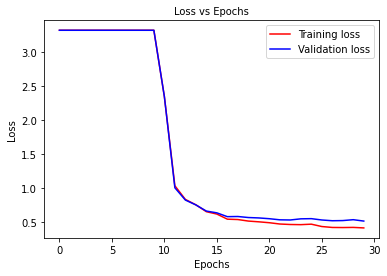

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


nn_128_nh_5_af_tanh_lr_0.01_init_random_optim_nesterov_batch_32_l2_0_epochs_30


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▁▁▁▁▁▁▁▁▁▂▆▇▇████████████████
training_loss,██████████▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,██████████▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▃▇▇▇████████████████
epoch,30
training_acc,0.89744
training_loss,0.41787
validation loss,0.5184
validation_accuracy,0.8815


wandb: Agent Starting Run: 5d7q5dm4 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


Stopping early at epoch 21. Best epoch: 16


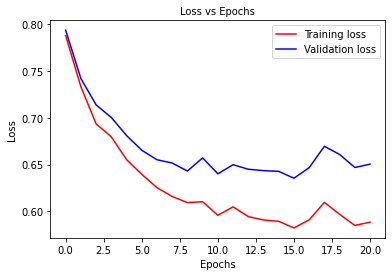

nn_256_nh_6_af_identity_lr_0.001_init_Xavier_optim_adam_batch_64_l2_0_epochs_30


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
training_acc,▁▃▄▄▅▆▆▇▇▇█▇▇████▇███
training_loss,█▆▅▄▃▃▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁
validation loss,█▆▄▄▃▂▂▂▁▂▁▂▁▁▁▁▁▃▂▂▂
validation_accuracy,▁▃▄▅▆▇▇█▇▇██▇███▇▇█▇▇
epoch,21
training_acc,0.85644
training_loss,0.58841
validation loss,0.6504
validation_accuracy,0.84317


wandb: Agent Starting Run: 6vo5lbrh with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam


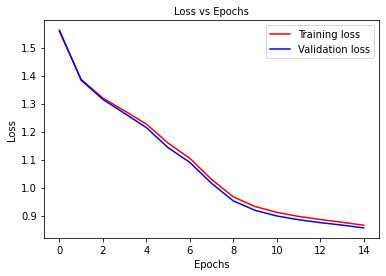

nn_128_nh_3_af_identity_lr_0.0001_init_random_optim_adam_batch_256_l2_0_epochs_15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▂▃▄▅▅▆▇▇▇█████
training_loss,█▆▆▅▅▄▃▃▂▂▁▁▁▁▁
validation loss,█▆▆▅▅▄▃▃▂▂▁▁▁▁▁
validation_accuracy,▁▂▃▄▅▆▆▇▇██████
epoch,15
training_acc,0.78915
training_loss,0.86527
validation loss,0.85572
validation_accuracy,0.794


wandb: Agent Starting Run: sblgtuzv with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


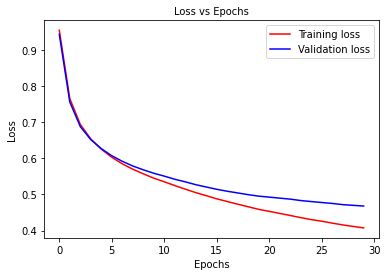

nn_64_nh_3_af_relu_lr_0.001_init_Xavier_optim_nesterov_batch_64_l2_0_epochs_30


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
training_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
epoch,30
training_acc,0.89763
training_loss,0.40755
validation loss,0.46804
validation_accuracy,0.88717


wandb: Agent Starting Run: waqum0v2 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


Stopping early at epoch 8. Best epoch: 3


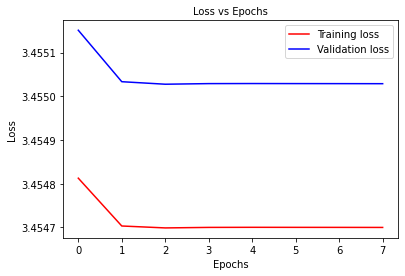

nn_512_nh_5_af_sigmoid_lr_0.01_init_Xavier_optim_nadam_batch_32_l2_0_epochs_40


epoch,▁▂▃▄▅▆▇█
training_acc,▁▁▁▁▁▁▁▁
training_loss,█▁▁▁▁▁▁▁
validation loss,█▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁
epoch,8
training_acc,0.10063
training_loss,3.4547
validation loss,3.45503
validation_accuracy,0.09433


wandb: Agent Starting Run: giq2wehm with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


Stopping early at epoch 18. Best epoch: 13


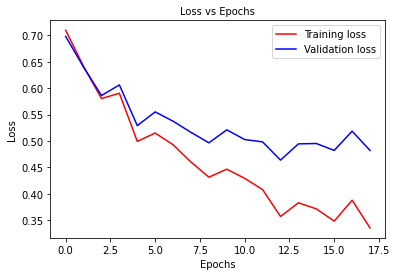

nn_128_nh_6_af_tanh_lr_0.001_init_Xavier_optim_rmsprop_batch_256_l2_0_epochs_20


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
training_acc,▁▂▃▃▅▄▅▅▆▅▆▆█▇▇█▇█
training_loss,█▇▆▆▄▄▄▃▃▃▃▂▁▂▂▁▂▁
validation loss,█▆▅▅▃▄▃▃▂▃▂▂▁▂▂▂▃▂
validation_accuracy,▁▂▃▂▅▄▅▅▆▅▆▆█▇▇▇▆█
epoch,18
training_acc,0.91154
training_loss,0.33534
validation loss,0.48212
validation_accuracy,0.88483


wandb: Agent Starting Run: kqam4gr8 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam


Stopping early at epoch 12. Best epoch: 7


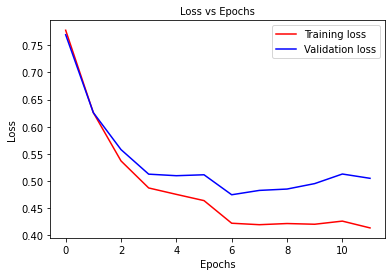

nn_64_nh_3_af_relu_lr_0.01_init_random_optim_adam_batch_256_l2_0_epochs_20


epoch,▁▂▂▃▄▄▅▅▆▇▇█
training_acc,▁▄▆▇▇▇██████
training_loss,█▅▃▂▂▂▁▁▁▁▁▁
validation loss,█▅▃▂▂▂▁▁▁▁▂▂
validation_accuracy,▁▅▆▇▇▇████▇▇
epoch,12
training_acc,0.8948
training_loss,0.41368
validation loss,0.50499
validation_accuracy,0.87733


wandb: Agent Starting Run: wvr0isgu with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


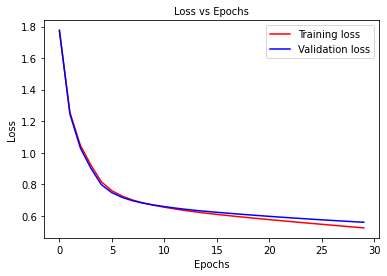

nn_512_nh_3_af_tanh_lr_0.01_init_random_optim_sgd_batch_32_l2_0_epochs_30


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▄▅▆▇▇▇▇▇▇▇▇██████████████████
training_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▇▇▇▇▇▇▇███████████████████
epoch,30
training_acc,0.86687
training_loss,0.52349
validation loss,0.55934
validation_accuracy,0.86233


wandb: Agent Starting Run: 85svkx6r with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


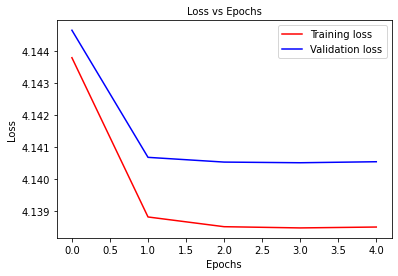

nn_512_nh_6_af_tanh_lr_0.01_init_Xavier_optim_adam_batch_32_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▁▁▁▁
validation loss,█▁▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09919
training_loss,4.13849
validation loss,4.14054
validation_accuracy,0.10733


wandb: Agent Starting Run: 8kd22ybr with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


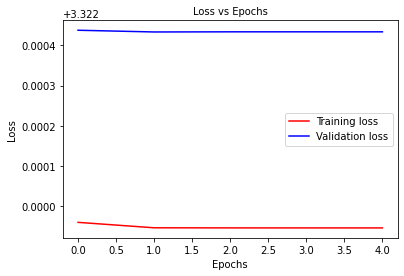

nn_256_nh_3_af_sigmoid_lr_0.0001_init_random_optim_momentum_batch_128_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,█▁▁▁▁
training_loss,█▁▁▁▁
validation loss,█▁▁▁▁
validation_accuracy,▁████
epoch,5
training_acc,0.09998
training_loss,3.32195
validation loss,3.32243
validation_accuracy,0.10017


wandb: Agent Starting Run: jddrcb6b with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


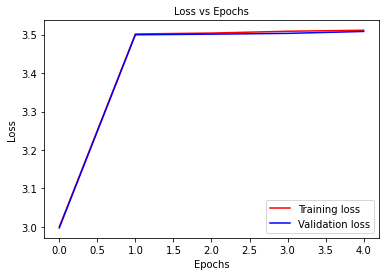

nn_512_nh_5_af_tanh_lr_0.01_init_random_optim_adam_batch_128_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,█▁▁▁▁
training_loss,▁████
validation loss,▁████
validation_accuracy,█▁▁▁▁
epoch,5
training_acc,0.09998
training_loss,3.51135
validation loss,3.50817
validation_accuracy,0.10017


wandb: Agent Starting Run: m0rwh3de with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


Stopping early at epoch 6. Best epoch: 1


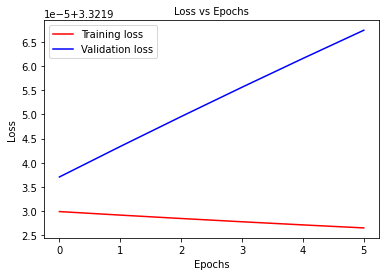

nn_256_nh_5_af_tanh_lr_0.001_init_random_optim_sgd_batch_256_l2_0_epochs_20


epoch,▁▂▄▅▇█
training_acc,▁█████
training_loss,█▇▅▃▂▁
validation loss,▁▂▄▅▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10067
training_loss,3.32193
validation loss,3.32197
validation_accuracy,0.094


wandb: Agent Starting Run: wcr0d50u with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


Stopping early at epoch 6. Best epoch: 1


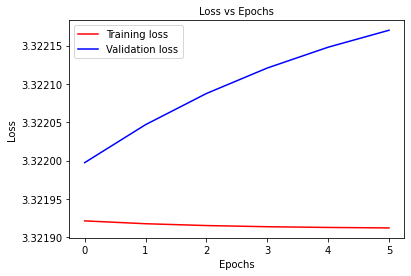

nn_64_nh_6_af_relu_lr_0.001_init_random_optim_momentum_batch_256_l2_0_epochs_15


epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▃▂▂▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10067
training_loss,3.32191
validation loss,3.32217
validation_accuracy,0.094


wandb: Agent Starting Run: fzotjvao with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


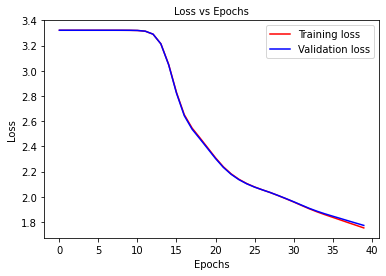

nn_32_nh_6_af_sigmoid_lr_0.0001_init_random_optim_adam_batch_32_l2_0_epochs_40


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▁▁▁▁▁▁▁▁▁▃▁▃▃▃▃▃▃▄▆▆▆▆▆▆▆▆▇▇▇██████████
training_loss,██████████████▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation loss,██████████████▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▃▁▃▃▃▃▃▃▄▆▆▆▆▆▆▆▆▇▇▇██████████
epoch,40
training_acc,0.48135
training_loss,1.75208
validation loss,1.77203
validation_accuracy,0.463


wandb: Agent Starting Run: fojs6lbg with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


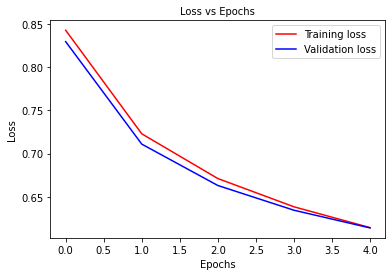

nn_128_nh_3_af_tanh_lr_0.01_init_Xavier_optim_sgd_batch_64_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▄▆▇█
training_loss,█▄▃▂▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
training_acc,0.84696
training_loss,0.61413
validation loss,0.61376
validation_accuracy,0.848


wandb: Agent Starting Run: zjdgmjs7 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov


Stopping early at epoch 6. Best epoch: 1


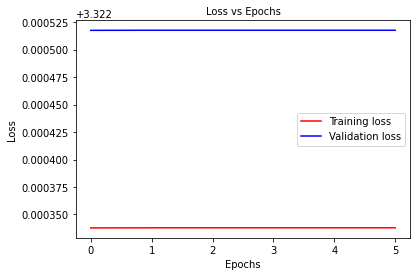

nn_64_nh_5_af_relu_lr_0.01_init_random_optim_nesterov_batch_64_l2_0_epochs_15


epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁
validation loss,▁█████
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.09998
training_loss,3.32234
validation loss,3.32252
validation_accuracy,0.10017


wandb: Agent Starting Run: w30ie8qg with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


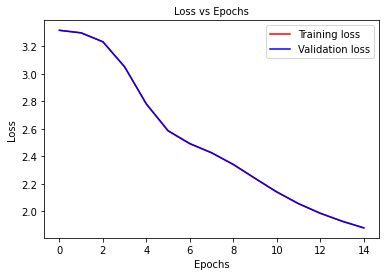

nn_32_nh_4_af_sigmoid_lr_0.0001_init_Xavier_optim_rmsprop_batch_128_l2_0_epochs_15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▅▄▃▃▃▄▆▆▇▇████
training_loss,███▇▅▄▄▄▃▃▂▂▂▁▁
validation loss,███▇▅▄▄▄▃▃▂▂▂▁▁
validation_accuracy,▁▅▄▃▃▃▄▅▆▇▇▇███
epoch,15
training_acc,0.41859
training_loss,1.87846
validation loss,1.87893
validation_accuracy,0.41817


wandb: Agent Starting Run: ms7xuso0 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


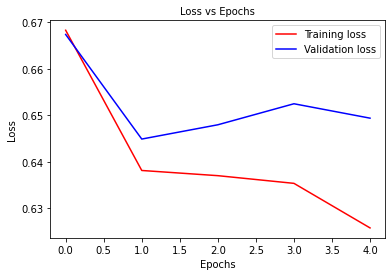

nn_32_nh_5_af_identity_lr_0.01_init_Xavier_optim_adam_batch_256_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▇▆▆█
training_loss,█▃▃▃▁
validation loss,█▁▂▃▂
validation_accuracy,▁▅▃▅█
epoch,5
training_acc,0.848
training_loss,0.62582
validation loss,0.64942
validation_accuracy,0.849


wandb: Agent Starting Run: 1wxtvlzg with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov


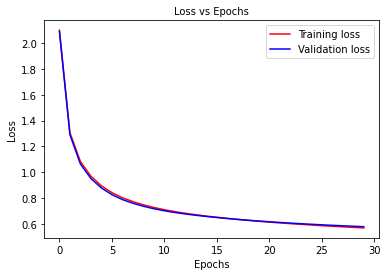

nn_64_nh_4_af_relu_lr_0.0001_init_Xavier_optim_nesterov_batch_32_l2_0_epochs_30


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
training_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇████████████████
epoch,30
training_acc,0.85994
training_loss,0.56972
validation loss,0.57917
validation_accuracy,0.861


wandb: Agent Starting Run: v099491f with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


Stopping early at epoch 6. Best epoch: 1


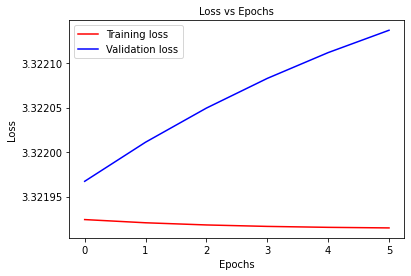

nn_64_nh_5_af_relu_lr_0.0001_init_random_optim_rmsprop_batch_128_l2_0_epochs_15


epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▄▂▁▁
validation loss,▁▃▄▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10063
training_loss,3.32191
validation loss,3.32214
validation_accuracy,0.09433


wandb: Agent Starting Run: l9yuu9d7 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


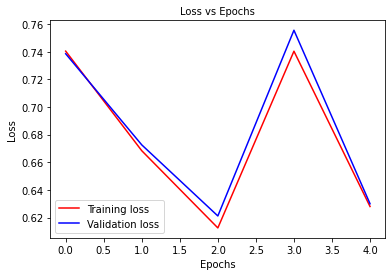

nn_128_nh_5_af_tanh_lr_0.01_init_Xavier_optim_adam_batch_256_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▃▄█▁▆
training_loss,█▄▁█▂
validation loss,▇▄▁█▁
validation_accuracy,▄▄█▁▅
epoch,5
training_acc,0.84424
training_loss,0.62796
validation loss,0.62996
validation_accuracy,0.84333


wandb: Agent Starting Run: kmd2j7f1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


Stopping early at epoch 15. Best epoch: 10


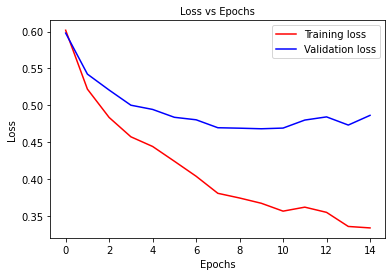

nn_256_nh_3_af_tanh_lr_0.001_init_random_optim_nadam_batch_128_l2_0_epochs_20


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▃▄▅▅▆▆▇▇▇▇▇▇██
training_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▁▁
validation loss,█▅▄▃▂▂▂▁▁▁▁▂▂▁▂
validation_accuracy,▁▃▅▆▆▆▆▇▇▇▇▇▇██
epoch,15
training_acc,0.91411
training_loss,0.3343
validation loss,0.48658
validation_accuracy,0.89283


wandb: Agent Starting Run: zg73h3x5 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum


Stopping early at epoch 6. Best epoch: 1


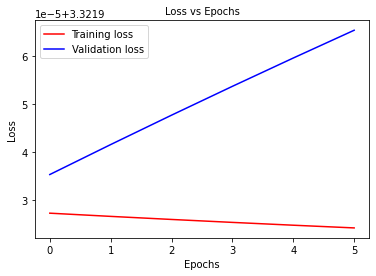

nn_32_nh_5_af_identity_lr_0.0001_init_random_optim_momentum_batch_256_l2_0_epochs_30


epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▆▅▄▂▁
validation loss,▁▂▄▅▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10067
training_loss,3.32192
validation loss,3.32197
validation_accuracy,0.094


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0hzppp6w with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


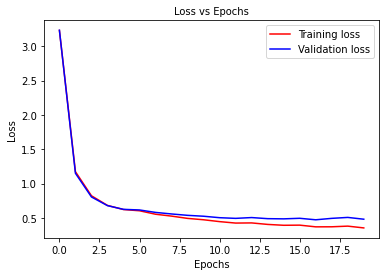

nn_128_nh_3_af_relu_lr_0.01_init_random_optim_nesterov_batch_64_l2_0_epochs_20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▆▇▇▇▇██████████████
training_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇████████████████
epoch,20
training_acc,0.90839
training_loss,0.3542
validation loss,0.48091
validation_accuracy,0.88717


wandb: Agent Starting Run: n499hdxv with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


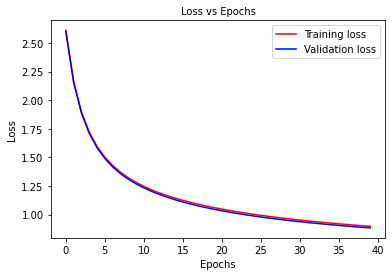

nn_256_nh_3_af_identity_lr_0.0001_init_Xavier_optim_sgd_batch_64_l2_0_epochs_40


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
training_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
epoch,40
training_acc,0.79137
training_loss,0.89732
validation loss,0.88363
validation_accuracy,0.7965


wandb: Agent Starting Run: o1gr7hv1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


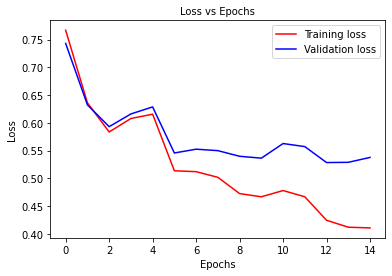

nn_128_nh_4_af_tanh_lr_0.001_init_random_optim_rmsprop_batch_32_l2_0_epochs_15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▄▅▄▅▆▆▆▇▇▇▇███
training_loss,█▅▄▅▅▃▃▃▂▂▂▂▁▁▁
validation loss,█▄▃▄▄▂▂▂▁▁▂▂▁▁▁
validation_accuracy,▁▅▅▅▅▇▇▇▇▇▇▇███
epoch,15
training_acc,0.89785
training_loss,0.41066
validation loss,0.53765
validation_accuracy,0.87267


wandb: Agent Starting Run: xcfcij15 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


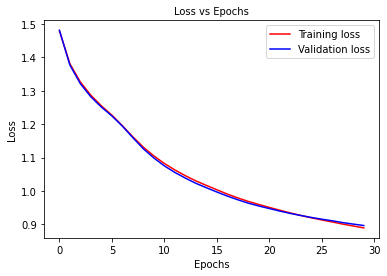

nn_64_nh_4_af_relu_lr_0.0001_init_random_optim_nadam_batch_64_l2_0_epochs_30


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▃▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇█████████████
training_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
validation loss,█▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇███████████████
epoch,30
training_acc,0.76781
training_loss,0.88957
validation loss,0.89671
validation_accuracy,0.76717


wandb: Agent Starting Run: hfag77v2 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


Stopping early at epoch 7. Best epoch: 2


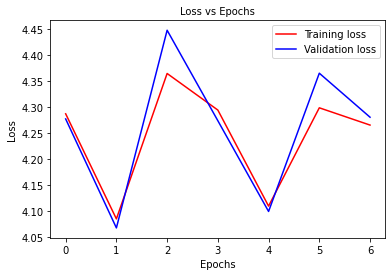

nn_256_nh_3_af_tanh_lr_0.01_init_random_optim_rmsprop_batch_256_l2_0_epochs_40


epoch,▁▂▃▅▆▇█
training_acc,███▁█▇▂
training_loss,▆▁█▆▂▆▆
validation loss,▅▁█▅▂▆▅
validation_accuracy,▁▁▁█▁▂▇
epoch,7
training_acc,0.09937
training_loss,4.26507
validation loss,4.28018
validation_accuracy,0.10567


wandb: Agent Starting Run: ml75ndbi with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov


Stopping early at epoch 17. Best epoch: 12


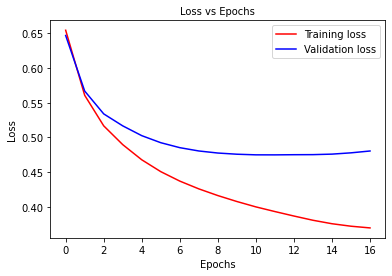

nn_32_nh_5_af_tanh_lr_0.01_init_Xavier_optim_nesterov_batch_128_l2_0_epochs_20


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
training_acc,▁▃▄▅▆▆▆▇▇▇▇▇█████
training_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁
validation loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▄▅▆▇▇▇▇████████
epoch,17
training_acc,0.90748
training_loss,0.36966
validation loss,0.48049
validation_accuracy,0.88667


wandb: Agent Starting Run: l7lrz2hi with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


Stopping early at epoch 8. Best epoch: 3


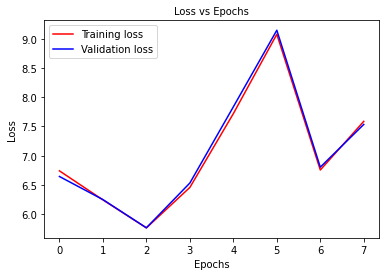

nn_512_nh_3_af_tanh_lr_0.01_init_random_optim_rmsprop_batch_256_l2_0_epochs_30


epoch,▁▂▃▄▅▆▇█
training_acc,▁███▁▁█▇
training_loss,▃▂▁▂▅█▃▅
validation loss,▃▂▁▃▅█▃▅
validation_accuracy,█▁▁▁██▁▂
epoch,8
training_acc,0.10043
training_loss,7.58801
validation loss,7.53545
validation_accuracy,0.09617


wandb: Agent Starting Run: u2zm03w7 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


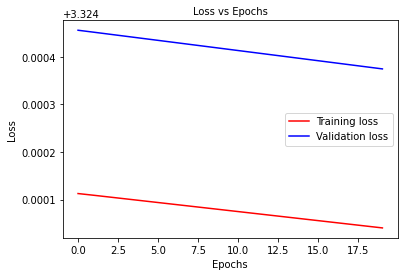

nn_512_nh_6_af_sigmoid_lr_0.001_init_Xavier_optim_momentum_batch_256_l2_0_epochs_20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
validation loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
training_acc,0.10024
training_loss,3.32404
validation loss,3.32437
validation_accuracy,0.09783


wandb: Agent Starting Run: ew1fsdi5 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


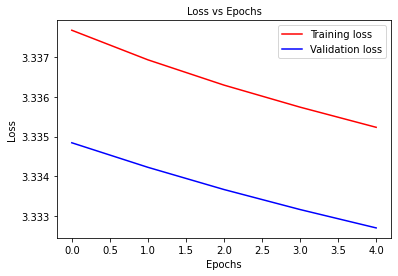

nn_128_nh_3_af_sigmoid_lr_0.01_init_random_optim_momentum_batch_128_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▆▄▂▁
validation loss,█▆▄▃▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09998
training_loss,3.33523
validation loss,3.33271
validation_accuracy,0.10017


wandb: Agent Starting Run: exvcyj1f with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


Stopping early at epoch 20. Best epoch: 15


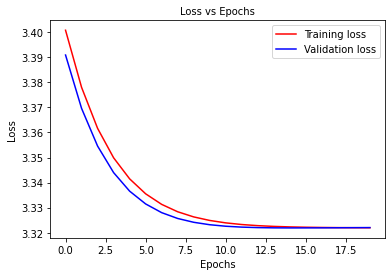

nn_32_nh_6_af_sigmoid_lr_0.0001_init_Xavier_optim_nesterov_batch_256_l2_0_epochs_40


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁████████
training_loss,█▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,████████████▁▁▁▁▁▁▁▁
epoch,20
training_acc,0.10063
training_loss,3.32196
validation loss,3.32204
validation_accuracy,0.09433


wandb: Agent Starting Run: y2dcgvgg with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


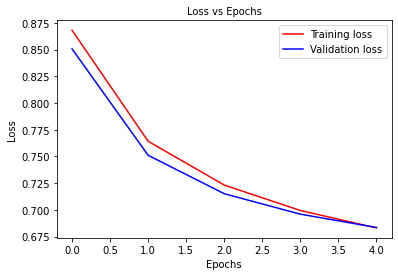

nn_32_nh_6_af_identity_lr_0.0001_init_Xavier_optim_rmsprop_batch_64_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▅▇██
training_loss,█▄▃▂▁
validation loss,█▄▂▂▁
validation_accuracy,▁▄▆██
epoch,5
training_acc,0.83241
training_loss,0.68314
validation loss,0.68357
validation_accuracy,0.83233


wandb: Agent Starting Run: 810kwil6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


Stopping early at epoch 6. Best epoch: 1


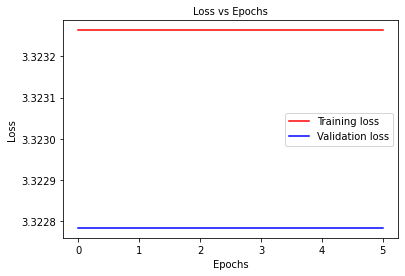

nn_64_nh_6_af_relu_lr_0.01_init_random_optim_nesterov_batch_32_l2_0_epochs_30


epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁
validation loss,▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.09998
training_loss,3.32326
validation loss,3.32278
validation_accuracy,0.10017


wandb: Agent Starting Run: nck1sjgg with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


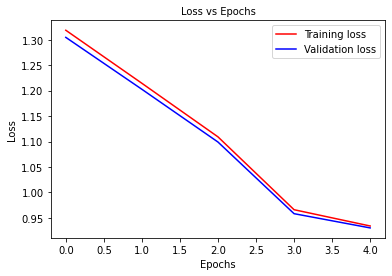

nn_256_nh_4_af_identity_lr_0.0001_init_random_optim_rmsprop_batch_32_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▃▅▇█
training_loss,█▆▄▂▁
validation loss,█▆▄▂▁
validation_accuracy,▁▃▆▇█
epoch,5
training_acc,0.766
training_loss,0.93392
validation loss,0.93014
validation_accuracy,0.77117


wandb: Agent Starting Run: z2zmuvt7 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


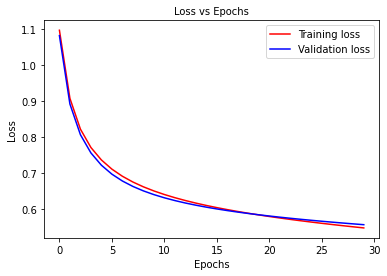

nn_512_nh_3_af_tanh_lr_0.0001_init_Xavier_optim_momentum_batch_32_l2_0_epochs_30


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
training_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
epoch,30
training_acc,0.86465
training_loss,0.5471
validation loss,0.55607
validation_accuracy,0.8685


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qvnx0nqq with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum


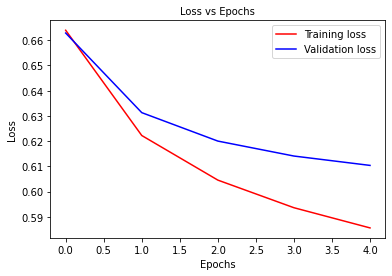

nn_512_nh_4_af_identity_lr_0.001_init_Xavier_optim_momentum_batch_32_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▅▆▇█
training_loss,█▄▃▂▁
validation loss,█▄▂▁▁
validation_accuracy,▁▆▇██
epoch,5
training_acc,0.85681
training_loss,0.58563
validation loss,0.6104
validation_accuracy,0.85217


wandb: Agent Starting Run: dtz3o9au with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


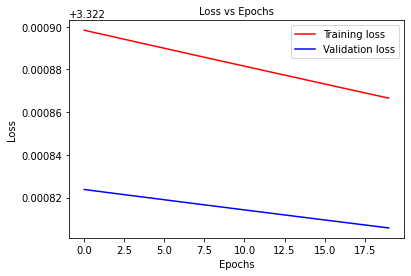

nn_64_nh_3_af_sigmoid_lr_0.001_init_random_optim_momentum_batch_64_l2_0_epochs_20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
validation loss,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
training_acc,0.09998
training_loss,3.32287
validation loss,3.32281
validation_accuracy,0.10017


wandb: Agent Starting Run: pamuyjqz with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nadam


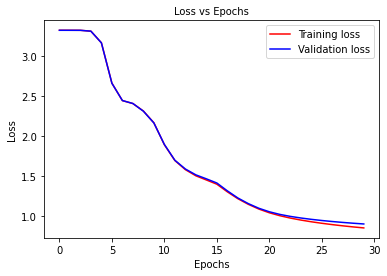

nn_128_nh_6_af_sigmoid_lr_0.0001_init_random_optim_nadam_batch_32_l2_0_epochs_30


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▁▁▂▂▂▂▂▃▃▄▅▅▅▅▆▇▇▇▇▇▇████████
training_loss,█████▆▆▅▅▅▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation loss,█████▆▅▅▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▂▂▂▂▂▃▃▄▅▅▅▅▆▇▇▇▇▇█████████
epoch,30
training_acc,0.80298
training_loss,0.85711
validation loss,0.90642
validation_accuracy,0.79983


wandb: Agent Starting Run: v7oax1ih with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


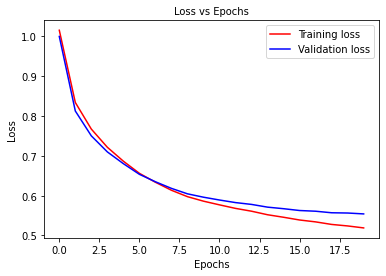

nn_32_nh_5_af_relu_lr_0.0001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▄▄▅▆▆▆▇▇▇▇▇▇███████
training_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
validation loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇████████
epoch,20
training_acc,0.87241
training_loss,0.51901
validation loss,0.55418
validation_accuracy,0.864


wandb: Agent Starting Run: 5ds1zo82 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


Stopping early at epoch 6. Best epoch: 1


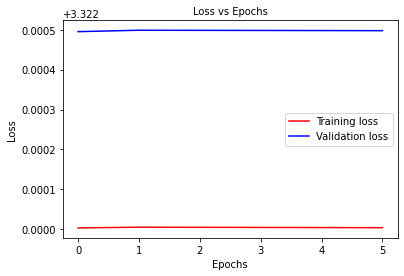

nn_256_nh_6_af_tanh_lr_0.01_init_random_optim_momentum_batch_128_l2_0_epochs_15


epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁█▇▅▅▃
validation loss,▁██▇▇▆
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.09998
training_loss,3.322
validation loss,3.3225
validation_accuracy,0.10017


wandb: Agent Starting Run: 9mis6ebx with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


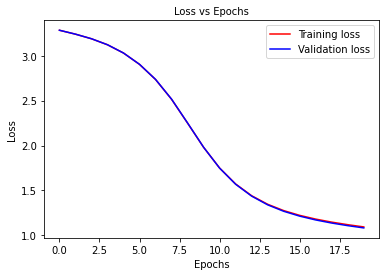

nn_256_nh_6_af_relu_lr_0.0001_init_Xavier_optim_momentum_batch_256_l2_0_epochs_20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▂▂▄▅▅▆▆▇▇▇▇▇██████
training_loss,███▇▇▇▆▆▅▄▃▃▂▂▂▁▁▁▁▁
validation loss,███▇▇▇▆▆▅▄▃▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▁▁▂▃▄▅▆▆▇▇▇▇▇██████
epoch,20
training_acc,0.723
training_loss,1.09374
validation loss,1.08253
validation_accuracy,0.73233


wandb: Agent Starting Run: v74s7zfs with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


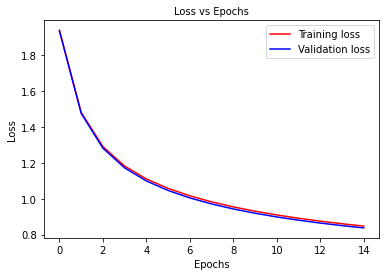

nn_128_nh_6_af_identity_lr_0.0001_init_Xavier_optim_momentum_batch_256_l2_0_epochs_15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▃▄▅▆▆▇▇▇▇▇████
training_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▃▄▅▆▆▇▇▇▇▇████
epoch,15
training_acc,0.79072
training_loss,0.84751
validation loss,0.83734
validation_accuracy,0.794


wandb: Agent Starting Run: id1xkbac with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


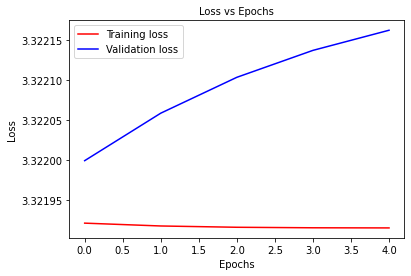

nn_32_nh_6_af_relu_lr_0.0001_init_random_optim_rmsprop_batch_32_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▄▂▁▁
validation loss,▁▄▅▇█
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10067
training_loss,3.32192
validation loss,3.32216
validation_accuracy,0.094


wandb: Agent Starting Run: 0ler1zov with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


Stopping early at epoch 7. Best epoch: 2


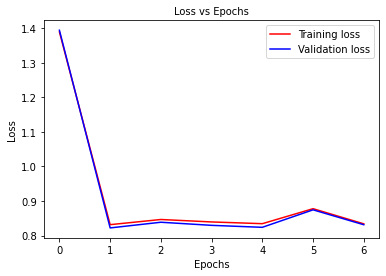

nn_32_nh_6_af_identity_lr_0.01_init_Xavier_optim_rmsprop_batch_64_l2_0_epochs_15


epoch,▁▂▃▅▆▇█
training_acc,▁█▇▇█▇█
training_loss,█▁▁▁▁▂▁
validation loss,█▁▁▁▁▂▁
validation_accuracy,▁█▇▇▇▇▇
epoch,7
training_acc,0.78993
training_loss,0.83407
validation loss,0.83143
validation_accuracy,0.7915


wandb: Agent Starting Run: w8n2snt1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


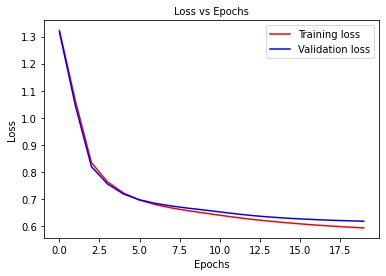

nn_256_nh_3_af_identity_lr_0.0001_init_random_optim_nadam_batch_128_l2_0_epochs_20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▄▆▇▇▇▇▇▇███████████
training_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▇▇▇██████████████
epoch,20
training_acc,0.85828
training_loss,0.59436
validation loss,0.61898
validation_accuracy,0.8565


wandb: Agent Starting Run: y4snr0u9 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam


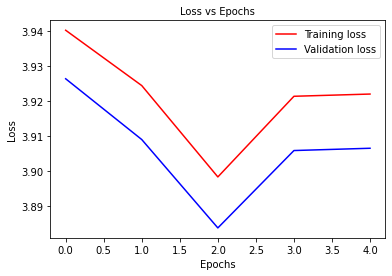

nn_256_nh_4_af_tanh_lr_0.01_init_Xavier_optim_adam_batch_32_l2_0_epochs_5


epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▅▁▅▅
validation loss,█▅▁▅▅
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09919
training_loss,3.92209
validation loss,3.90658
validation_accuracy,0.10733


wandb: Agent Starting Run: wymygm3k with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


<ipython-input-5-c84dc1e08e2f>:4: RuntimeWarning: divide by zero encountered in log2
  J=(-1*np.sum(np.multiply(y_true,np.log2(y_hat))))/batch_size
<ipython-input-5-c84dc1e08e2f>:4: RuntimeWarning: invalid value encountered in multiply
  J=(-1*np.sum(np.multiply(y_true,np.log2(y_hat))))/batch_size
<ipython-input-5-c84dc1e08e2f>:4: RuntimeWarning: divide by zero encountered in log2
  J=(-1*np.sum(np.multiply(y_true,np.log2(y_hat))))/batch_size
<ipython-input-5-c84dc1e08e2f>:4: RuntimeWarning: invalid value encountered in multiply
  J=(-1*np.sum(np.multiply(y_true,np.log2(y_hat))))/batch_size


Stopping early at epoch 8. Best epoch: 3


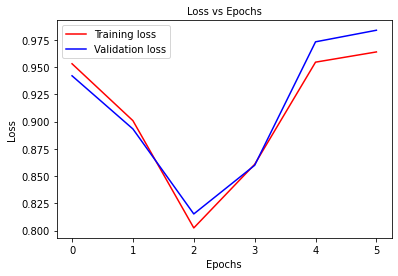

nn_128_nh_4_af_identity_lr_0.01_init_random_optim_nadam_batch_32_l2_0_epochs_15


epoch,▁▂▃▄▅▆▇█
training_acc,▄▄▆▅▂▃▁█
training_loss,█▅▁▄██
validation loss,▆▄▁▃██
validation_accuracy,▄▄▆▅▂▂▁█
epoch,8
training_acc,0.82491
training_loss,nan
validation loss,nan
validation_accuracy,0.82633


wandb: Agent Starting Run: ctbiu8u6 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


Stopping early at epoch 12. Best epoch: 7


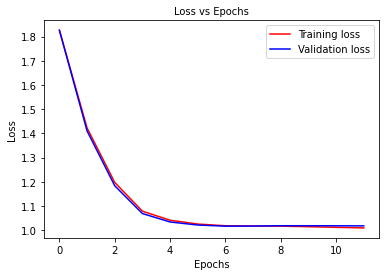

nn_64_nh_6_af_identity_lr_0.001_init_random_optim_adam_batch_128_l2_0_epochs_40


epoch,▁▂▂▃▄▄▅▅▆▇▇█
training_acc,▁▅▇█████████
training_loss,█▅▃▂▁▁▁▁▁▁▁▁
validation loss,█▄▂▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▇█████████
epoch,12
training_acc,0.747
training_loss,1.00946
validation loss,1.01793
validation_accuracy,0.75033


wandb: Agent Starting Run: 8x03j0oz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam


Stopping early at epoch 13. Best epoch: 8


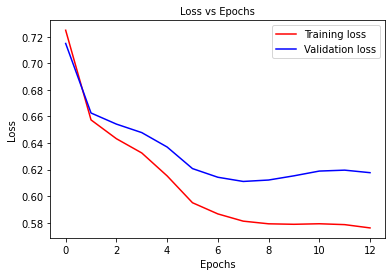

nn_512_nh_3_af_identity_lr_0.001_init_random_optim_adam_batch_256_l2_0_epochs_20


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
training_acc,▁▄▅▅▆▇▇██████
training_loss,█▅▄▄▃▂▁▁▁▁▁▁▁
validation loss,█▄▄▃▃▂▁▁▁▁▂▂▁
validation_accuracy,▁▅▅▅▆▇▇▇▇▇███
epoch,13
training_acc,0.8598
training_loss,0.57607
validation loss,0.61764
validation_accuracy,0.8565


wandb: Agent Starting Run: za7hvchy with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


Stopping early at epoch 6. Best epoch: 1


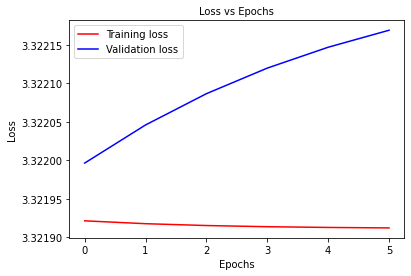

nn_32_nh_6_af_identity_lr_0.001_init_random_optim_nesterov_batch_256_l2_0_epochs_20


epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▃▂▂▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10067
training_loss,3.32191
validation loss,3.32217
validation_accuracy,0.094


wandb: Agent Starting Run: dv2iixhz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 512
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: sgd


Stopping early at epoch 38. Best epoch: 33


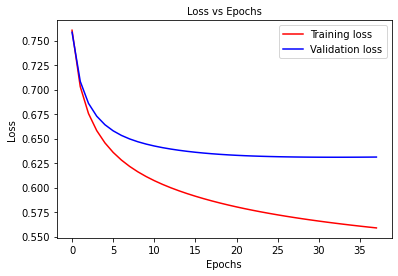

nn_512_nh_6_af_identity_lr_0.01_init_Xavier_optim_sgd_batch_64_l2_0_epochs_40


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
training_acc,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
training_loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch,38
training_acc,0.86057
training_loss,0.55889
validation loss,0.63118
validation_accuracy,0.848


wandb: Agent Starting Run: atndjgok with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


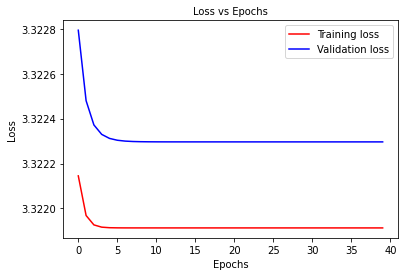

nn_64_nh_3_af_sigmoid_lr_0.0001_init_random_optim_nesterov_batch_128_l2_0_epochs_40


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▁██████████████████████████████████████
training_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
training_acc,0.10067
training_loss,3.32191
validation loss,3.3223
validation_accuracy,0.094


wandb: Agent Starting Run: 89yjlf5r with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


Stopping early at epoch 6. Best epoch: 1


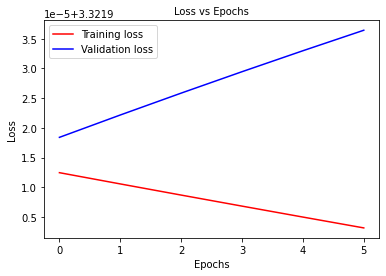

nn_256_nh_4_af_tanh_lr_0.0001_init_random_optim_sgd_batch_32_l2_0_epochs_40


epoch,▁▂▄▅▇█
training_acc,█▂▁▁▁▁
training_loss,█▇▅▄▂▁
validation loss,▁▂▄▅▇█
validation_accuracy,█▂▁▁▁▁
epoch,6
training_acc,0.10067
training_loss,3.3219
validation loss,3.32194
validation_accuracy,0.094


wandb: Agent Starting Run: 1c9oca4n with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


In [ ]:
### Change the parameters if you want to
sweep_config = {
  "name": "Cross Entropy Loss-Final(5)",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "neurons_per_layer": {
            "values": [32, 64, 128, 256, 512]
        },
         "num_hidden_layers": {
            "values": [3, 4, 5, 6]
        },
        "activation_function": {
            "values": ["sigmoid", "relu", "tanh","identity"]
        },
        "learning_rate": {
            "values": [0.01, 0.001, 0.0001]
        },
        "init": {
            "values": ["Xavier", "random"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nesterov", "adam", "nadam", "rmsprop"]
        },
        "batch_size": {
            "values": [32,64,128,256]
        },
        "L2_lamb": {
            "values": [0, 0.05, 0.5]
        },
        "epochs": {
            "values": [5, 15, 20, 30, 40]
        } 
    }
}

sweep_id = wandb.sweep(sweep_config,  entity="shashwat_mm19b053", project="Assignment-1")
wandb.agent(sweep_id,project='Assignment-1', function=NN_wandb_sweep, count=150)

In [13]:
####### Model evaluation on test data using best configuration

# Configuration
num_neurons=128
hidden_layer=3
activation_function='tanh'
learning_rate=0.0001
init='Xavier'
optimizer='adam'
batch_size=32
lambda_val=0
epochs=30

def NN_test_fit(num_neurons,hidden_layer,activation_function,learning_rate,init,optimizer,batch_size,lambda_val,epochs):
         # For mse change loss parameter
        NN=NeuralNetwork(num_layers=hidden_layer+2,activation_function=activation_function,loss="cross_entropy",batch_size=batch_size,lambda_val=lambda_val)

        neurons_per_layer = [num_features] + [num_neurons]*NN.num_hidden_layers + [num_classes]
        parameters, old_parameters,v,m = NN.weight_bias_initialize(neurons_per_layer,init="Xavier") # initialize the parameters and past updates matrices
        
        
  
        train_epoch_cost = []
        count = 1
        t=1
        patience=5
        best_loss=np.inf
        best_epoch=0

        while count<=epochs:
            count=count+1
            remaining_data=X.shape[1] % NN.batch_size
            for i in range(0, X.shape[1], NN.batch_size):
                if X.shape[1]-i==remaining_data:
                    NN.batch_size=remaining_data
         
                output,H,A = NN.forward_propagation(X[:,i:i+NN.batch_size],parameters)
                gradients = NN.backpropagate(output,y_encoded[:,i:i+NN.batch_size],H,A,parameters)
                optim=NN_optimizers(parameters,gradients,learning_rate,old_parameters,v,m,t,NN.num_layers)

                if optimizer == 'sgd':
                  parameters=optim.sgd()
                if optimizer == 'nesterov':
                  parameters,old_parameters=optim.nesterov_gd()
                if optimizer=='adam':
                  parameters,v,m,t=optim.adam()
                if optimizer == 'rmsprop':
                  parameters,v =optim.rmsprop()
                elif optimizer == 'momentum':
                  parameters,old_parameters = optim.momentum_gd()
                elif optimizer == 'nadam':
                  parameters,v,m,t=optim.nadam()
              

        # loss for the full training set
            full_output, _, _ = NN.forward_propagation(X, parameters)
            cost = loss_computation(y_encoded, full_output, NN.loss,no_sample_train, NN.lambda_val, parameters,NN.num_layers)
            train_epoch_cost.append(cost)
        
            
        # Training accuracy at the end of the epoch
            train_predictions = NN.predict(X, parameters)
            train_acc = NN.accuracy(y, train_predictions)
        
        test_predictions = NN.predict(X_test,parameters)
        test_accuracy = NN.accuracy(y_test, test_predictions)
        print(f"Train Accuracy:{train_acc}")
        print(f"Test Accuracy:{test_accuracy}")

        return test_predictions, train_predictions


In [14]:
test_pred,train_pred=NN_test_fit(num_neurons,hidden_layer,activation_function,learning_rate,init,optimizer,batch_size,lambda_val,epochs)

Train Accuracy:0.92315
Test Accuracy:0.88


# Confusion Matrix

In [16]:
class_labels={0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}
def plot_confusion_matrix(y_true,y_pred):
  num_classes = len(class_labels)
  conf_matrix = np.zeros((len(class_labels), len(class_labels)))
  for i in range(len(y_true)):
    true_label = y_true[i]
    pred_label = y_pred[i]
    conf_matrix[true_label, pred_label] += 1
  fig, ax = plt.subplots(figsize=(9, 9))
  sns.heatmap(conf_matrix, annot=True, cmap='YlGn', fmt='g', ax=ax,cbar=False)
  ax.set_xlabel('Predicted labels',size=14)
  ax.set_xticklabels(class_labels.values(),size=11)
  ax.set_ylabel('True labels',size=14)
  ax.set_yticklabels(class_labels.values(),size=11)
  ax.set_title('Confusion Matrix',size=16)
  return fig

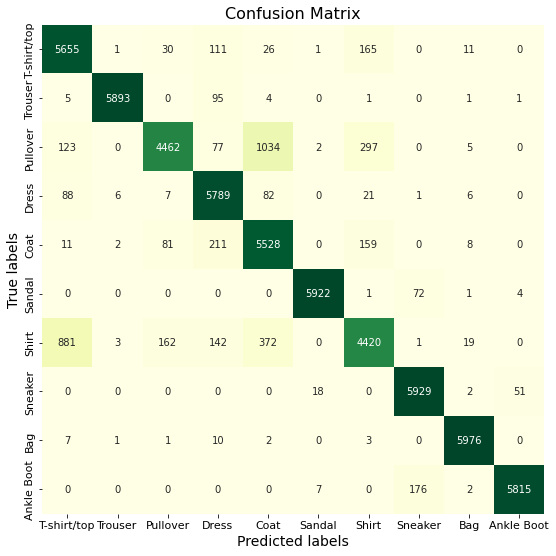

In [ ]:
wandb.init(project="Assignment-1", entity="shashwat_mm19b053", name="Confusion Matrix")
wandb.log({"Confusion Matrix(Train Set)" : wandb.Image(plot_confusion_matrix(y,train_pred))})

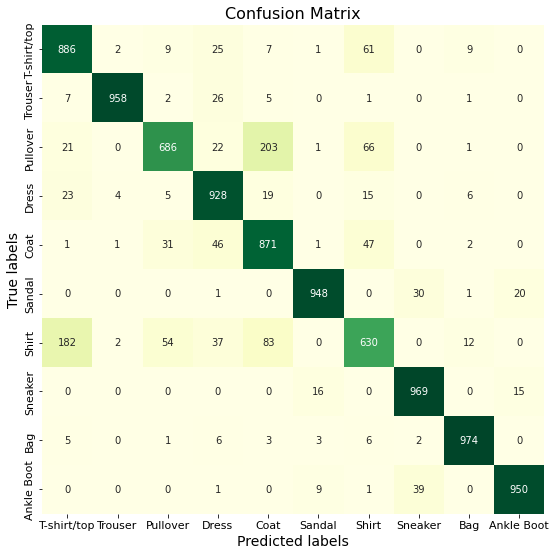

In [ ]:
wandb.init(project="Assignment-1", entity="shashwat_mm19b053", name="Confusion Matrix")
wandb.log({"Confusion Matrix(Test Set)" : wandb.Image(plot_confusion_matrix(y_test,test_pred))})

In [ ]:
num_neurons=128
hidden_layer=3
activation_function='tanh'
learning_rate=0.0001
init='Xavier'
optimizer='adam'
batch_size=32
lambda_val=0
epochs=30

In [ ]:
#####
# For Comparison: Cross-Entropy and MSE
 
def NN_loss_fit(num_neurons,hidden_layer,activation_function,learning_rate,init,optimizer,batch_size,lambda_val,epochs,loss):
      
        NN=NeuralNetwork(num_layers=hidden_layer+2,activation_function=activation_function,loss=loss,batch_size=batch_size,lambda_val=lambda_val)

        neurons_per_layer = [num_features] + [num_neurons]*NN.num_hidden_layers + [num_classes]
        parameters, old_parameters,v,m = NN.weight_bias_initialize(neurons_per_layer,init="Xavier") # initialize the parameters and past updates matrices
        
        
  
        train_epoch_cost = []
        train_accuracy = []
        validation_accuracy = []
        count = 1
        t=1

        while count<=epochs:
            count=count+1
            remaining_data=X_train.shape[1] % NN.batch_size
            for i in range(0, X_train.shape[1], NN.batch_size):
                if X_train.shape[1]-i==remaining_data:
                    NN.batch_size=remaining_data
         
                output,H,A = NN.forward_propagation(X_train[:,i:i+NN.batch_size],parameters)
                gradients = NN.backpropagate(output,y_train_encoded[:,i:i+NN.batch_size],H,A,parameters)
                optim=NN_optimizers(parameters,gradients,learning_rate,old_parameters,v,m,t,NN.num_layers)

                if optimizer == 'sgd':
                  parameters=optim.sgd()
                if optimizer == 'nesterov':
                  parameters,old_parameters=optim.nesterov_gd()
                if optimizer=='adam':
                  parameters,v,m,t=optim.adam()
                if optimizer == 'rmsprop':
                  parameters,v =optim.rmsprop()
                elif optimizer == 'momentum':
                  parameters,old_parameters = optim.momentum_gd()
                elif optimizer == 'nadam':
                  parameters,v,m,t=optim.nadam()
              

        # loss for the full training set
            full_output, _, _ = NN.forward_propagation(X_train, parameters)
            cost = loss_computation(y_train_encoded, full_output, NN.loss,no_sample_train, NN.lambda_val, parameters,NN.num_layers)
            train_epoch_cost.append(cost)
        
            
        # Training accuracy at the end of the epoch
            train_predictions = NN.predict(X_train, parameters)
            train_acc = NN.accuracy(y_train, train_predictions)
            train_accuracy.append(train_acc)
       # Validation Accuracy        
            val_predictions = NN.predict(X_val, parameters)
            val_acc = NN.accuracy(y_val, val_predictions) 
            validation_accuracy.append(val_acc)

        
        
        return train_accuracy, validation_accuracy

# MSE Vs Cross-Entropy

In [ ]:
num_neurons=128
hidden_layer=3
activation_function='tanh'
learning_rate=0.0001
init='Xavier'
optimizer='adam'
batch_size=32
lambda_val=0
epochs=30

In [ ]:
train_accuracy_CE,validation_accuracy_CE=NN_loss_fit(128,3,'tanh',0.0001,'Xavier','adam',32,0,30,loss='cross_entropy')

In [ ]:
train_accuracy_MSE,validation_accuracy_MSE=NN_loss_fit(128,3,'tanh',0.0001,'Xavier','adam',32,0,30,loss='mse')

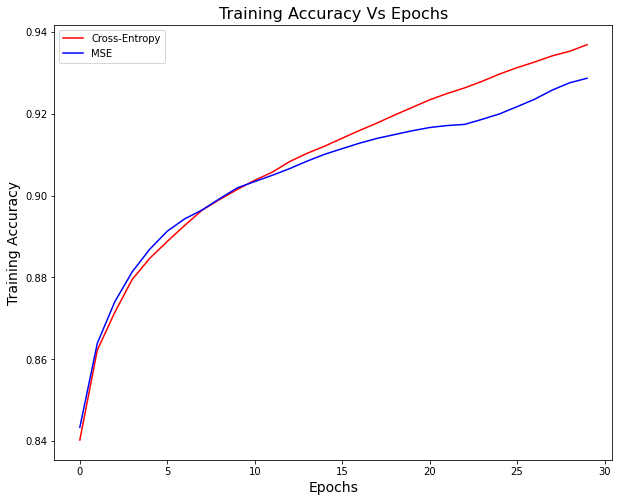

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(list(range(0,len(train_accuracy_CE))), train_accuracy_CE, 'r')
ax.plot(list(range(0,len(train_accuracy_MSE))), train_accuracy_MSE, 'b')
ax.set_xlabel('Epochs',size=14)
ax.set_ylabel('Training Accuracy',size=14)
ax.set_title('Training Accuracy Vs Epochs',size=16)
ax.legend(['Cross-Entropy','MSE'])
fig.show()

In [ ]:
wandb.init(project="Assignment-1", entity="shashwat_mm19b053", name="Config-1")
wandb.log({"Training Accuracy-1(MSE Vs CE)" : wandb.Image(fig)})

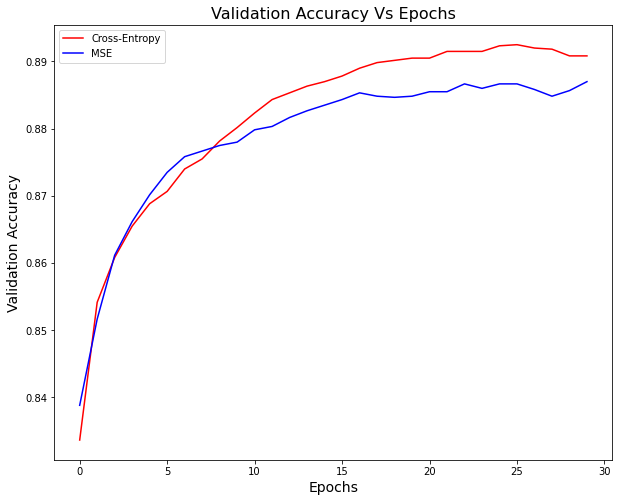

In [ ]:
fig2, ax = plt.subplots(figsize=(10, 8))
ax.plot(list(range(0,len(validation_accuracy_CE))), validation_accuracy_CE, 'r')
ax.plot(list(range(0,len(validation_accuracy_MSE))), validation_accuracy_MSE, 'b')
ax.set_xlabel('Epochs',size=14)
ax.set_ylabel('Validation Accuracy',size=14)
ax.set_title('Validation Accuracy Vs Epochs',size=16)
ax.legend(['Cross-Entropy','MSE'])
fig2.show()

In [ ]:
wandb.init(project="Assignment-1", entity="shashwat_mm19b053", name="Config-1")
wandb.log({"Validation Accuracy-1(MSE Vs CE)" : wandb.Image(fig2)})